In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from keras import backend

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [7]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    r'/kaggle/input/rice-leaf-dataset-from-mendeley-data/Rice Leaf Disease Images',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5932 files belonging to 4 classes.


In [8]:
class_names= dataset.class_names
print(class_names)
len(dataset)

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']


186

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 2 3 1 0 3 1 1 1 0 3 2 0 3 2 3 2 1 2 2 3 2 0 3 3 0 3 1 1 0 2]


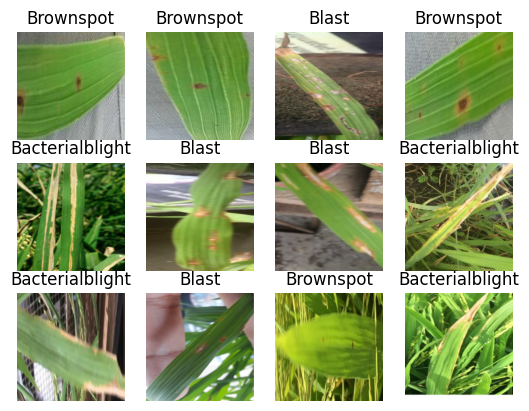

In [10]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [11]:
len(dataset)

186

In [12]:
train_size=0.8
len(dataset)*train_size

148.8

In [13]:
train_ds = dataset.take(148)
len(train_ds)

148

In [14]:
test_ds=dataset.skip(148)
len(test_ds)

38

In [15]:
val_size= 0.1
len(dataset)*val_size

18.6

In [16]:
val_ds=test_ds.take(18)
len(val_ds)

18

In [17]:
test_ds=test_ds.skip(18)
len(test_ds)

20

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
train_ds, val_ds,test_ds= get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

148
18
20


In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
   layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
   layers.Rescaling(1./255),
])

In [22]:
data_augmentation= tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
  2/148 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.1797 - loss: 1.3924  

I0000 00:00:1717858158.172772     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 ━━━━━━━━━━━━━━━━━━━━ 83s 407ms/step - accuracy: 0.4034 - loss: 1.2123 - val_accuracy: 0.6632 - val_loss: 0.8773
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 49s 328ms/step - accuracy: 0.7062 - loss: 0.7860 - val_accuracy: 0.7865 - val_loss: 0.6160
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 320ms/step - accuracy: 0.7899 - loss: 0.5683 - val_accuracy: 0.8472 - val_loss: 0.4118
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.8308 - loss: 0.4419 - val_accuracy: 0.8490 - val_loss: 0.3794
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.8874 - loss: 0.2762 - val_accuracy: 0.8333 - val_loss: 0.3929
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 317ms/step - accuracy: 0.8914 - loss: 0.3069 - val_accuracy: 0.9340 - val_loss: 0.1844
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 47s 320ms/step - accuracy: 0.9439 - loss: 0.1456 - val_accuracy: 0.9062 - val_loss: 0.2399
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 48s 325ms/step - accuracy: 0.9502 - loss: 0.1435 - val

In [27]:
scores = model.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9973 - loss: 0.0072


In [28]:
scores

[0.005523114465177059, 0.9984375238418579]

In [29]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 148}

In [30]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [31]:
type(history.history['loss'])

list

In [32]:
len(history.history['loss'])

20

In [33]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0506820678710938,
 0.7477856278419495,
 0.5558077096939087,
 0.42067888379096985,
 0.29387277364730835]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

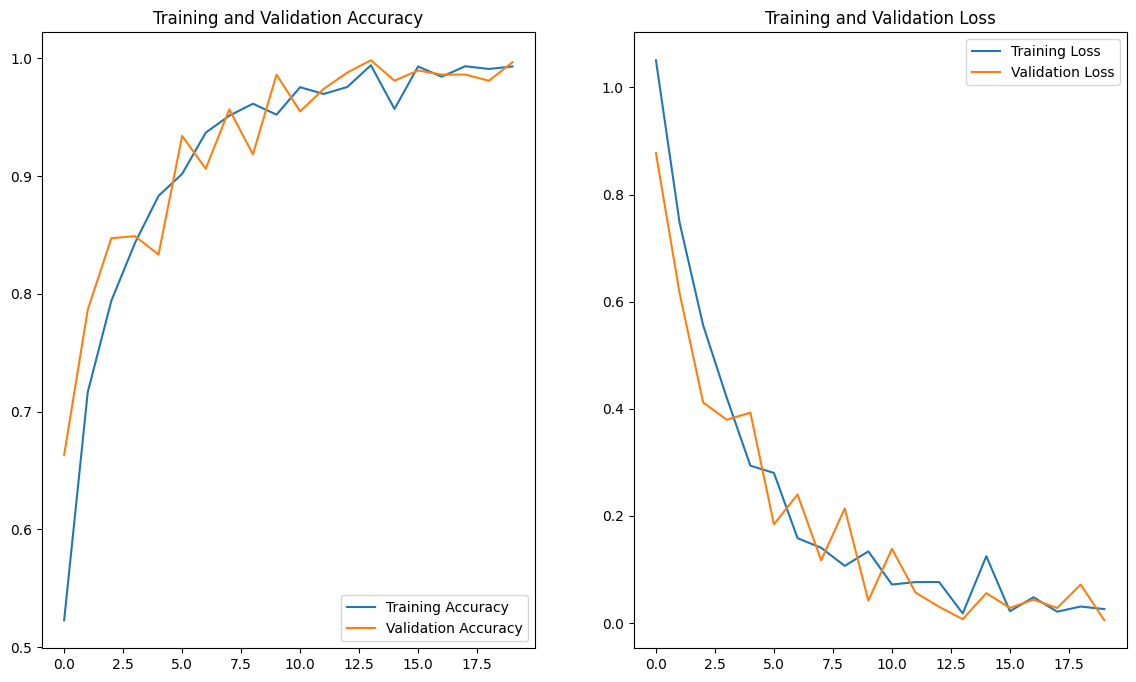

In [36]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Brownspot
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
predicted label: Brownspot


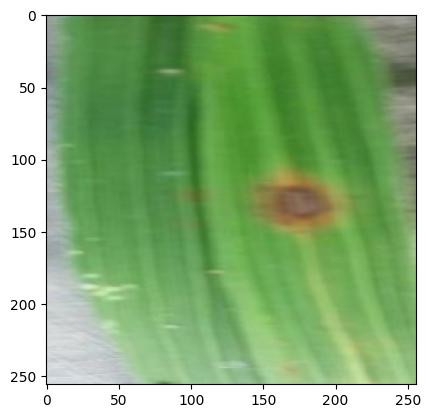

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


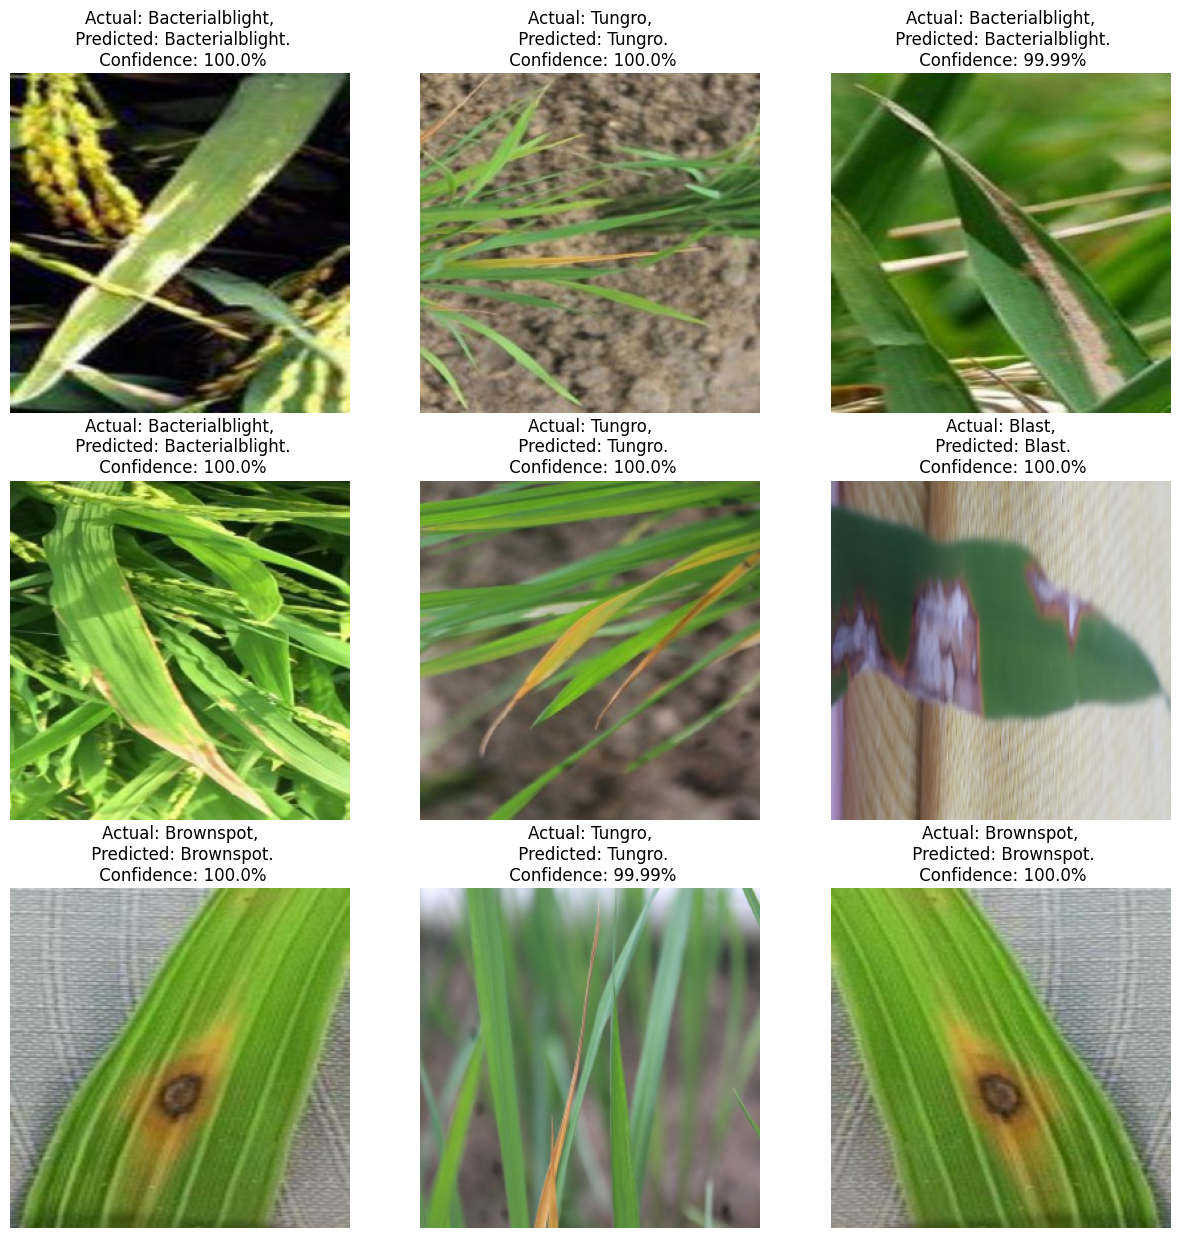

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [44]:
model.export('/kaggle/working/padipest_model')

Saved artifact at '/kaggle/working/padipest_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138252316561424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138252316558960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138252316565120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138252316561248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138252316562304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138252316566000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138252316567232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138252316568112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138252316564768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138252316568640: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [46]:
model.save('/kaggle/working/padipest_model.h5')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


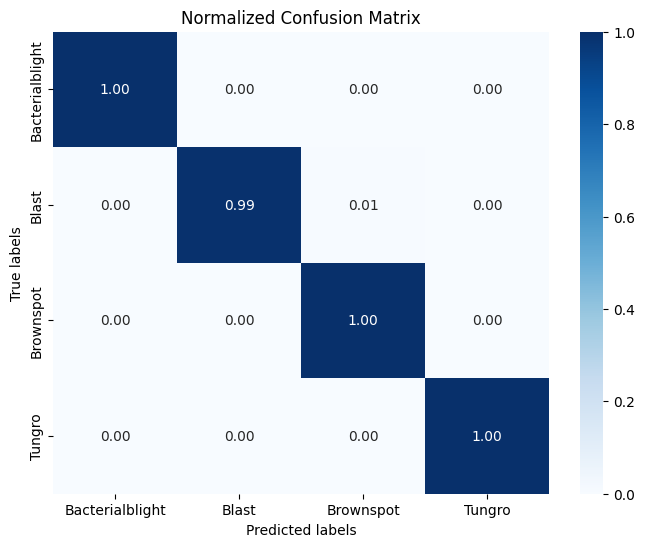

In [47]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels for the test dataset
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
predicted_labels = np.argmax(model.predict(test_images), axis=-1)

# Create confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure for the plot
plt.figure(figsize=(8, 6))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [48]:
from sklearn.metrics import classification_report

# Generate classification report
target_names = class_names  # Use the class names as target names
report = classification_report(test_labels, predicted_labels, target_names=target_names)

# Print the classification report
print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       173
          Blast       1.00      0.99      1.00       158
      Brownspot       0.99      1.00      1.00       165
         Tungro       1.00      1.00      1.00       144

       accuracy                           1.00       640
      macro avg       1.00      1.00      1.00       640
   weighted avg       1.00      1.00      1.00       640



In [50]:
!zip -r padipest_model.zip /kaggle/working

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/padipest_model.h5 (deflated 13%)
updating: kaggle/working/.virtual_documents/ (stored 0%)
updating: kaggle/working/models/ (stored 0%)
updating: kaggle/working/padipest_model/ (stored 0%)
updating: kaggle/working/padipest_model/saved_model.pb (deflated 87%)
updating: kaggle/working/padipest_model/variables/ (stored 0%)
updating: kaggle/working/padipest_model/variables/variables.data-00000-of-00001 (deflated 8%)
updating: kaggle/working/padipest_model/variables/variables.index (deflated 69%)
updating: kaggle/working/padipest_model/assets/ (stored 0%)
updating: kaggle/working/padipest_model/fingerprint.pb (stored 0%)
